<b>Diabetes Data Set</b> (reference to UCI Machine Learning Repository <a href="https://archive.ics.uci.edu/ml/datasets/diabetes">description</a>)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8

from IPython.display import display

import numpy as np
np.set_printoptions(precision=4, threshold=10000, linewidth=100, edgeitems=999, suppress=True)

import pandas as pd
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 200)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('precision', 6)

import warnings
warnings.simplefilter("ignore")

import seaborn as sns
sns.set()

from sklearn.preprocessing import LabelEncoder

from outlierdetection import *

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython

tb 2018-09-07 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.1
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit


In [2]:
# Seed random generators for repro 
SEED = 2017
np.random.seed(SEED)  

In [3]:
# https://archive.ics.uci.edu/ml/datasets/diabetes
dataframe = pd.read_csv("data/diabetic_data.csv")
dataframe.drop('encounter_id', axis=1, inplace=True)
dataframe.drop('patient_nbr', axis=1, inplace=True)
dataframe.drop('payer_code', axis=1, inplace=True)
dataframe.drop('weight', axis=1, inplace=True)

In [4]:
# provide classification labels
def readmit_group_classify(readmitted):
    # https://siemar14.github.io/Final+Project.html
    # Simple target for readmit status, 0 or 1. May make more complex later
    # 0 - not readmitted
    # 0 - readmitted > 30 days
    # 1 - readmitted < 30 days
    #
    if readmitted == 'NO':
        return 0
    elif readmitted == '>30':
        return 0
    else:
        return 1

dataframe['readmitted'] = dataframe['readmitted'].apply(readmit_group_classify)
cols = list(dataframe)
cols.insert(0, cols.pop(cols.index('readmitted')))
dataframe = dataframe.ix[:, cols]

feature_names = dataframe.columns[1:]
target_names = ['no', 'readmitted']

In [5]:
# Transform data form categorial to numeric
cat_variables = [i for i in dataframe.columns[1:] if dataframe[i].dtype == 'object']
encods = [LabelEncoder() for col in cat_variables]
for i, col in enumerate(cat_variables):
    dataframe[col] = encods[i].fit_transform(dataframe[col].astype(str))

In [6]:
# Check for NaNs and if scaling is required - look for categorial data that need transformation
display(dataframe.head())
display(dataframe.describe())

,readmitted,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,0,3,0,0,6,25,1,1,38,41,0,1,0,0,0,124,650,670,1,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,0
1,0,3,0,1,1,1,7,3,0,59,0,18,0,0,0,143,79,121,9,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1
2,0,1,0,2,1,1,7,2,0,11,5,13,2,0,1,454,78,767,6,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,1,1
3,0,3,1,3,1,1,7,2,0,44,1,16,0,0,0,554,97,248,7,2,2,1,1,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,3,1,0,0,0,0,0,1
4,0,3,1,4,1,1,7,1,0,51,0,8,0,0,0,54,24,86,5,2,2,1,1,1,1,1,0,2,1,0,1,1,1,1,0,0,0,0,2,1,0,0,0,0,0,1


,readmitted,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.0,101766.0,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,0.111599,2.598776,0.462443,6.096702,2.024006,3.715642,5.754437,4.395987,11.708871,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,336.864365,277.799471,286.331712,7.422607,1.983914,1.893383,1.195596,1.015319,1.006928,1.000884,1.050410,0.000010,1.121219,1.101547,0.000226,1.071989,1.062585,1.003066,1.000295,0.000029,0.000393,0.0,0.0,1.405469,1.006898,0.000128,0.000010,0.000020,0.000010,0.538048,0.770031
std,0.314874,0.938415,0.498649,1.594084,1.445403,5.280166,4.064081,2.985108,17.507131,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,160.650069,154.297281,180.651386,1.933600,0.309922,0.517917,0.435442,0.134652,0.086992,0.031956,0.241057,0.003135,0.364232,0.343916,0.015032,0.271523,0.252738,0.057550,0.020791,0.005429,0.020312,0.0,0.0,0.838798,0.084414,0.011302,0.003135,0.004433,0.003135,0.498553,0.420815
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,5.000000,1.000000,1.000000,1.000000,2.000000,0.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,259.000000,142.000000,139.000000,6.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,0.000000,6.000000,1.000000,1.000000,7.000000,4.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,298.000000,260.000000,256.000000,8.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,3.000000,1.000000,7.000000,3.000000,4.000000,7.000000,6.000000,19.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,435.000000,376.000000,381.000000,9.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,5.000000,2.000000,9.000000,8.000000,28.000000,25.000000,14.000000,72.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,716.000000,748.000000,789.000000,16.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.00000

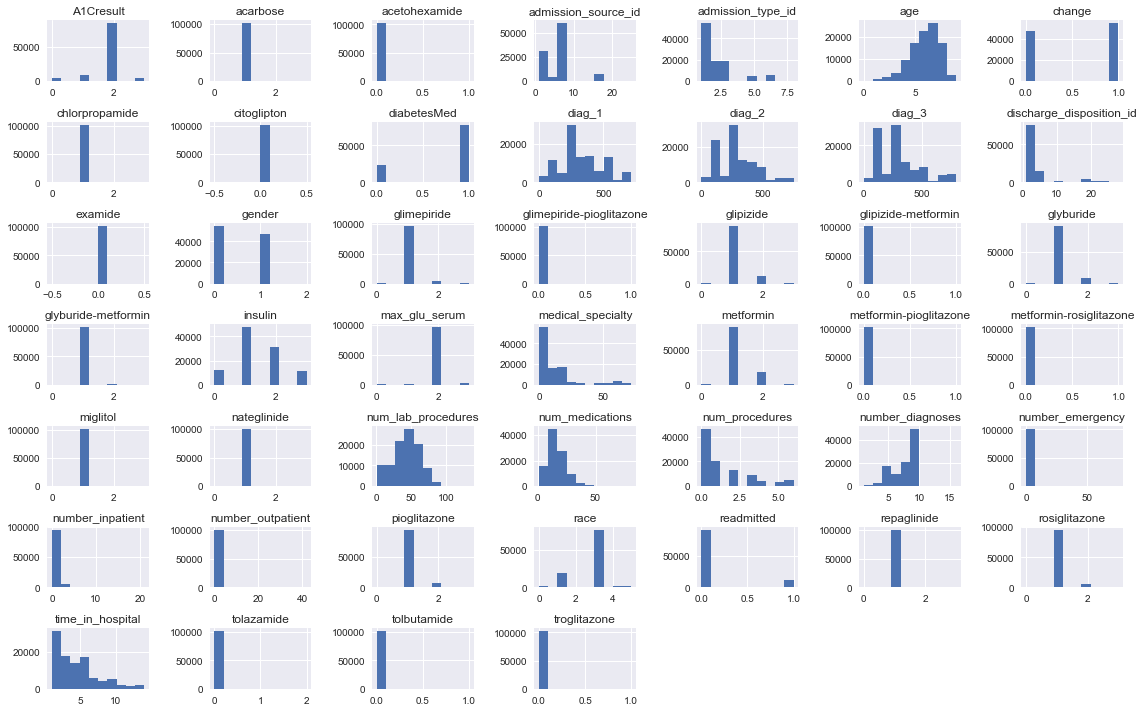

In [7]:
# check features and their individual distribution - watch for outliers
dataframe.hist(figsize=(16,10));
plt.tight_layout()

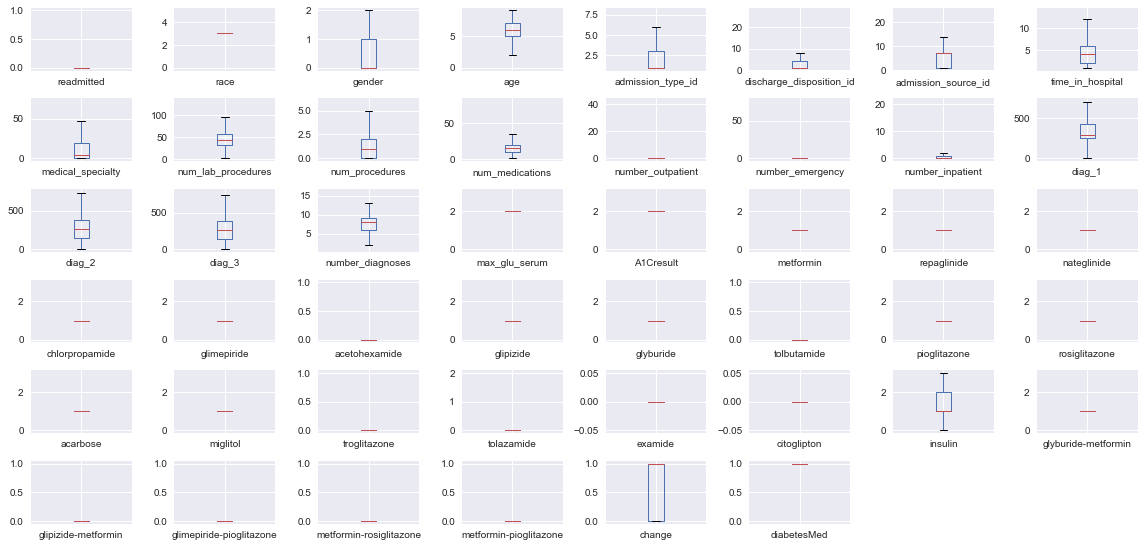

In [8]:
dataframe.plot(kind= 'box' , subplots=True, layout=(8,8), sharex=False, sharey=False, figsize=(16,10));
plt.tight_layout()

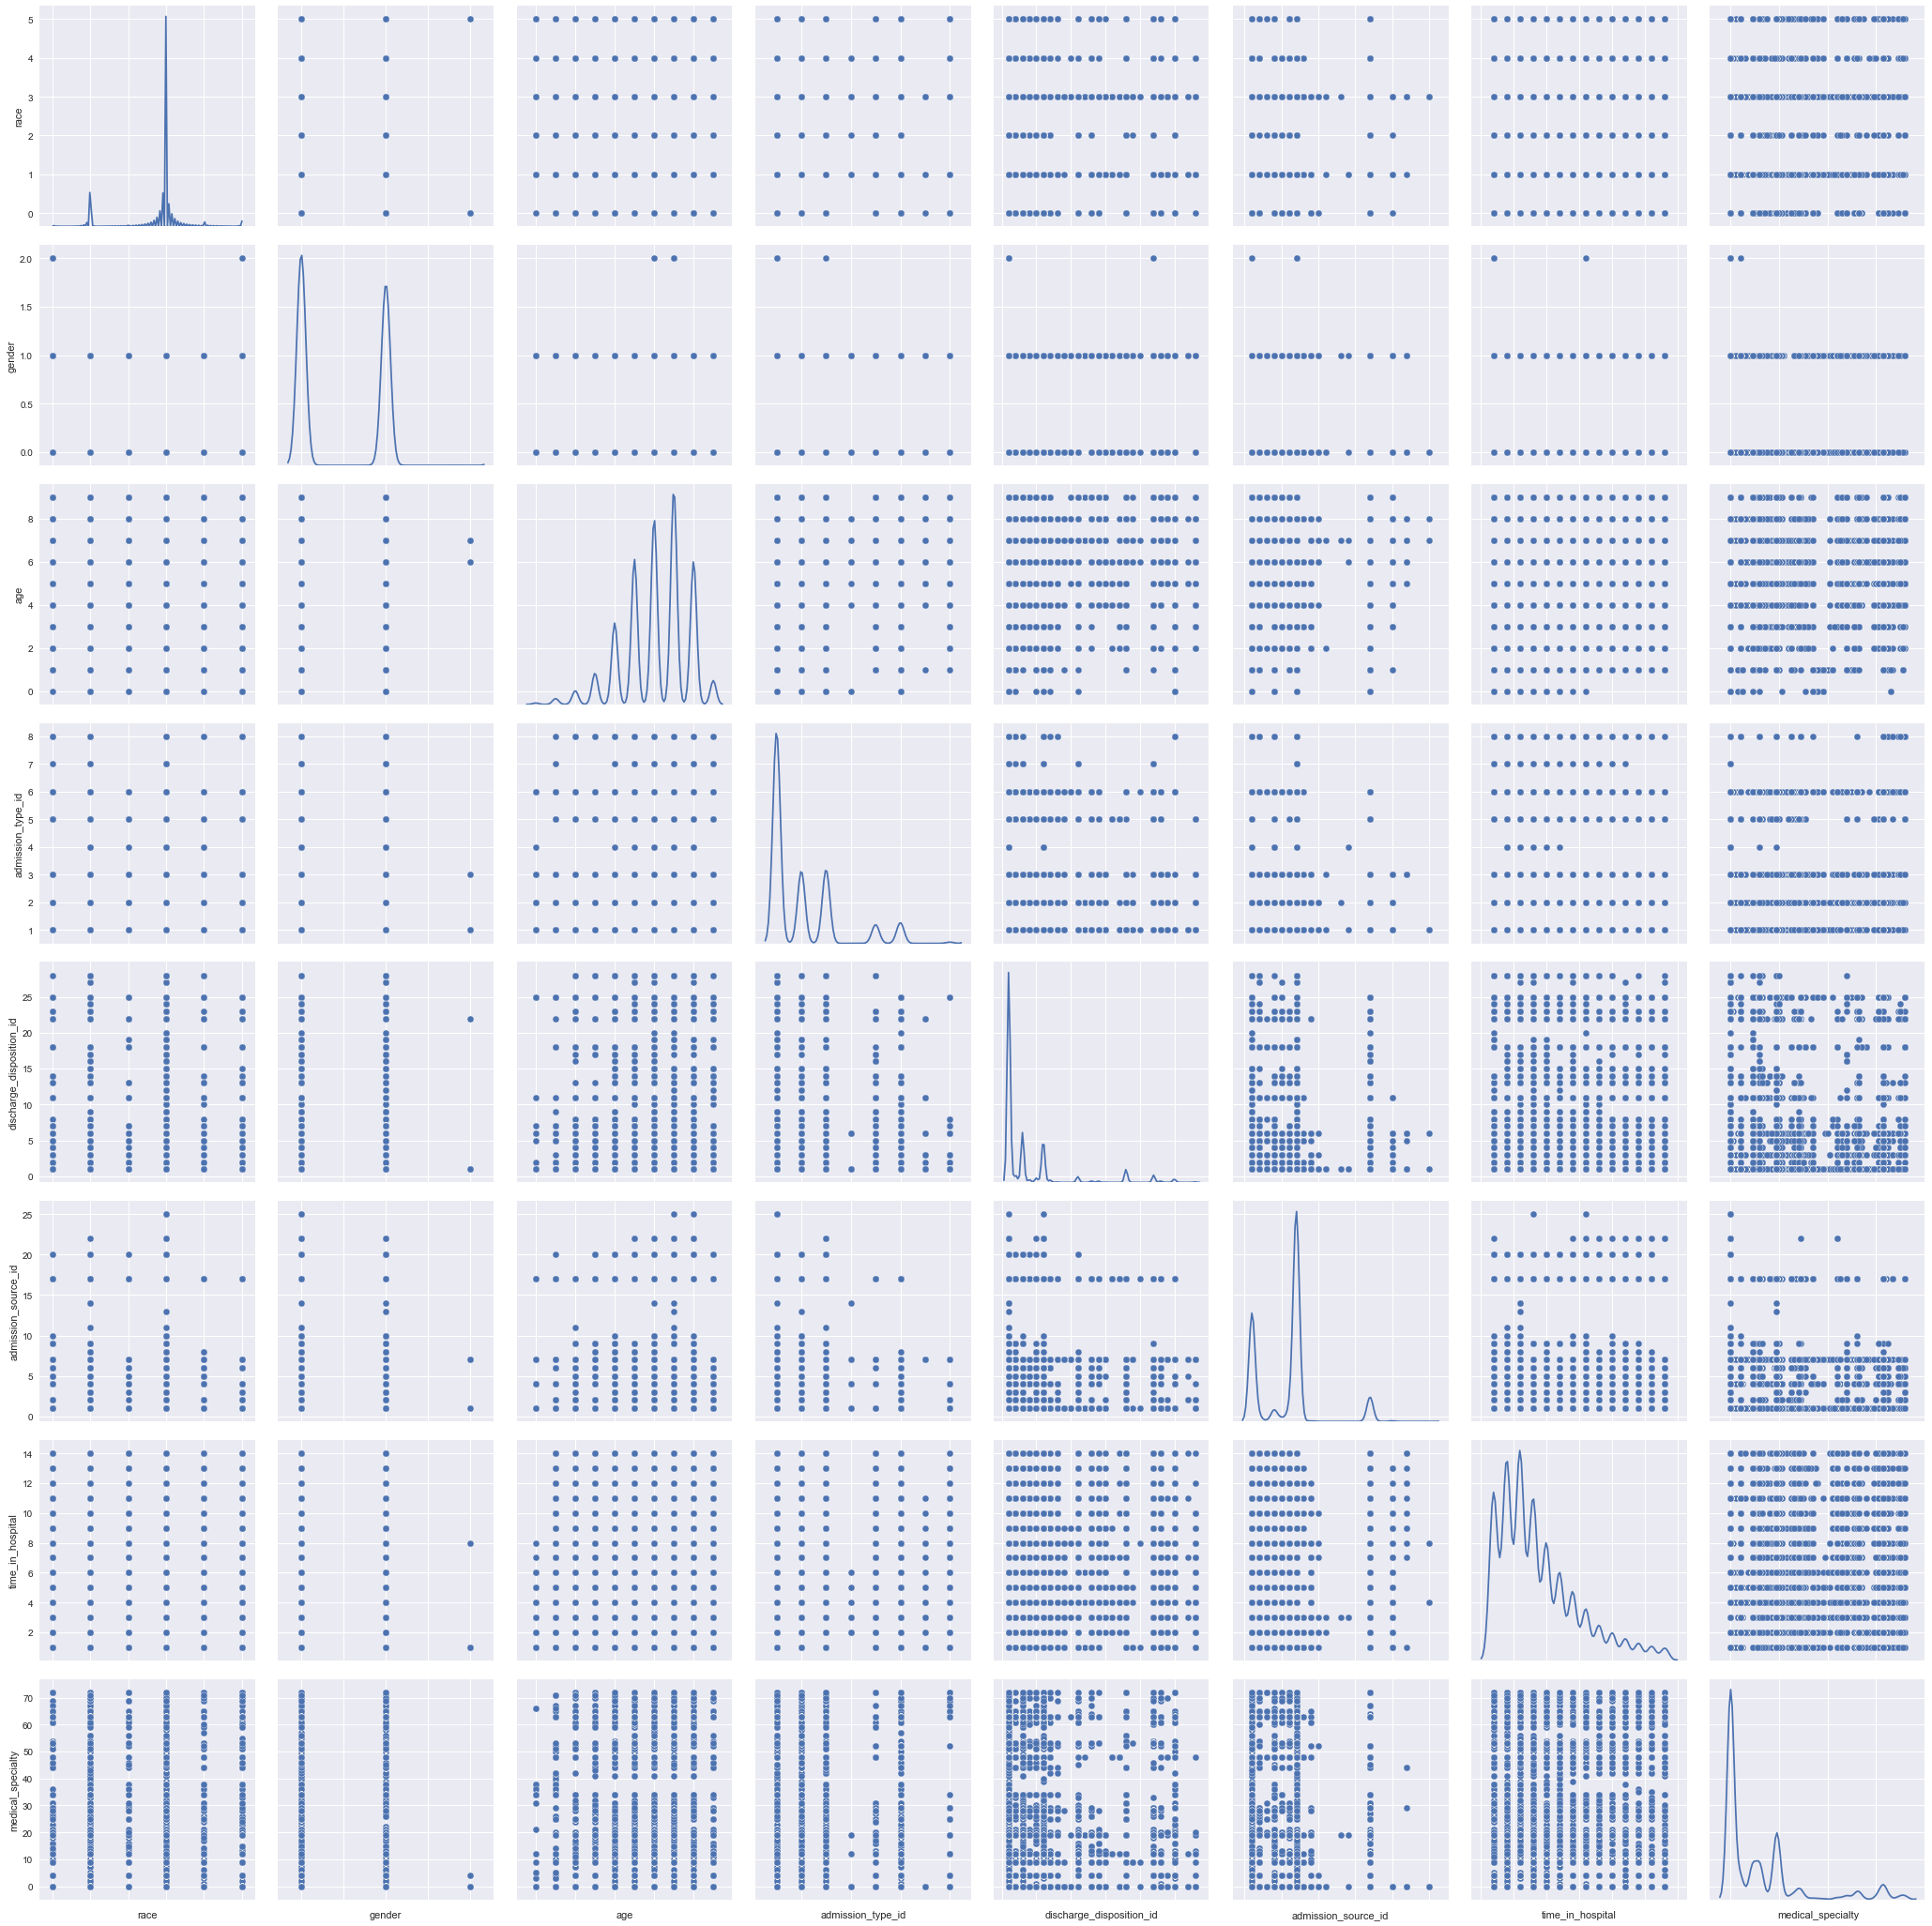

In [9]:
# Produce a scatter matrix for each pair of features in the data - plot provides insight 
# into the data distributon for the individual features
# Note the result below is an image - you can zoom in to see details
mx_plot = sns.pairplot(dataframe[feature_names[0:8]], diag_kind="kde", size=3.6)
mx_plot.set(xticklabels=[])

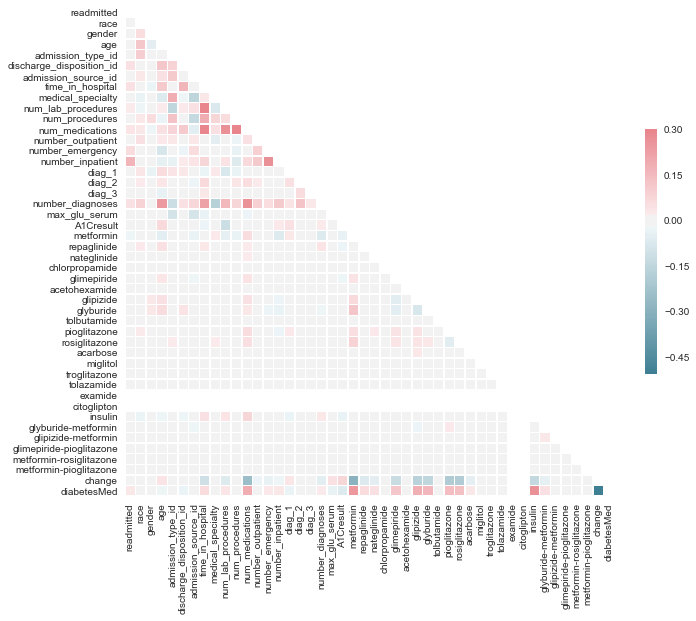

In [10]:
# Correlation analysis - watch for uncorrelated features that don't contribute
import seaborn as sns

sns.set(style="white")

# Compute the correlation matrix
corr = dataframe.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [11]:
# remove columns that don't contribute
dataframe.drop('examide', axis=1, inplace=True)
dataframe.drop('citoglipton', axis=1, inplace=True)

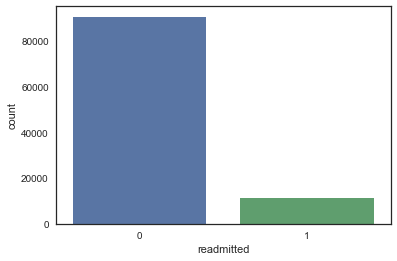

In [12]:
# check class distribution and if calsses are balanced
sns.countplot(dataframe["readmitted"])